In [3]:
import torch
import replicate
import requests
import json
import openai
import os                     
from model import ResNet9
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
torch.cuda.empty_cache()

In [6]:
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu") -> I have a cuda compatible gpu but it runs out of memory
model = to_device(ResNet9(3, 38), device) 
model_path = 'saved_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [11]:
with open('class_labels.json', 'r') as f:
    class_labels = json.load(f)

def predict_image(img, model):
    """Converts image to array and returns the predicted class with the highest probability."""
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    # This picks the index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return class_labels[preds[0].item()]


In [12]:
def preprocess_image(image_path):
    """Load image, convert to PNG, and return tensor."""
    img = Image.open(image_path)
    
    # Convert image to PNG format
    png_path = image_path.rsplit('.', 1)[0] + '.png'
    img.save(png_path, 'PNG')
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    img_tensor = transform(img)
    
    return img_tensor, png_path


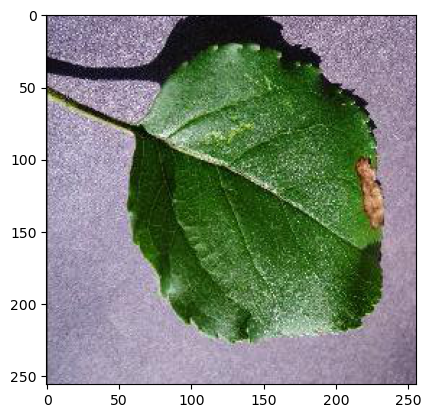

Uploaded Image Predicted as: Apple___Black_rot


In [26]:

uploaded_image_path = "/home/glaurung/generative-disease-prediction/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot/0b37761a-de32-47ee-a3a4-e138b97ef542___JR_FrgE.S 2908_270deg.JPG"
img_tensor, uploaded_image_path = preprocess_image(uploaded_image_path)

# Display the image
plt.imshow(img_tensor.permute(1, 2, 0))
plt.show()

# Make a prediction
predicted_class = predict_image(img_tensor, model)
print('Uploaded Image Predicted as:', predicted_class)


In [27]:
output = predicted_class.split("___")
plant = output[0].replace("_", " ")
disease = output[1].replace("_", " ")
print(plant)
print(disease)

Apple
Black rot


In [29]:
with open('api.key', 'r') as file:
    content = file.read()

openai.api_key = content

In [40]:
prompt = f"Show the single leaf but with increased prevalence of {disease} in the {plant} leaf. Make the background black so that only the leaf is visible."
mask_path="/home/glaurung/generative-disease-prediction/mask.png"
print(prompt)

Show the single 1 leaf but with increased prevalence of Black rot in the Apple leaf. Make the background black so that only the leaf is visible.


In [37]:
# Download the image Dall-E generates
def download_image(url, save_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

In [41]:
response = openai.Image.create_edit(
  image=open(uploaded_image_path, 'rb'),
  mask=open(mask_path, 'rb'),
  prompt=prompt,
  n=3,
  size="256x256"
)

In [1]:
for index, item in enumerate(response['data']):
    generated_image_path = f'generated_image{index}'
    image_url = item['url']
    download_image(image_url, generated_image_path)
    generated_img_tensor, generated_image_path = preprocess_image(generated_image_path)
    generated_predicted_class = predict_image(generated_img_tensor, model)
    if generated_predicted_class == predicted_class:
        print(f"Accurately generated plant with {predicted_class}: {image_url}")
        plt.imshow(generated_img_tensor.permute(1, 2, 0))
        plt.show()
    else:
        print(f"Predicted {generated_predicted_class} but should be {predicted_class}  |  {image_url}")
        plt.imshow(generated_img_tensor.permute(1, 2, 0))
        plt.show()


NameError: name 'response' is not defined